# Cluster AI 2019 - Grupo 7

## Trabajo práctico integrador -  SUACI

**Etapa 02: Clustering** 

In [1]:
# importamos librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importamos librerias de clustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

Para el ejercicio de clusterización vamos a basar nuestro análisis en el dataset con los contactos realizados al SUACI en el año calendario 2019. <br>Tomamos esta decisión a partir de la necesidad de reducir la cantidad de samples por el elevado costo computacional de los algoritmos involucrados. Dada esta restricción, elegimos la base 2019 por contar con los datos más recientes.

In [3]:
# importamos el dataset del año 2019
base2019 = pd.read_csv('/Users/fer/Downloads/DATASCIENCE/CLUSTER AI/GRUPO TP/SUACI/sistema-unico-de-atencion-ciudadana-2019.csv', delimiter=',', header = 0, index_col = "contacto")

Para el ejercicio de clusterización nos proponemos trabajar en la identificación de zonas en la Ciudad Autónoma de Buenos Aires con problemáticas similares, definidas las mismas a partir de los contactos realizados al SUACI.
Utilizamos a este efecto la variable "categoría" que aporta una categorización descriptiva del tipo de contacto. <br>
Los contactos realizados al SUACI se catalogan en primer lugar en 213 conceptos, que es el nivel más bajo de categorización. Esos conceptos se agrupan en 58 subcategorías, las cuales a su vez pertenecen a 17 categorías diferentes, siendo éste último el orden superior. <br> 
A efectos del problema propuesto no nos interesa el canal a través del cual se realizó el contacto ni el género del denunciante, así como la fecha en que se registró el mismo, en tanto vamos a tomar el horizonte temporal de todos los contactos realizados durante el año calendario 2019.<br>
Definimos entonces un nuevo dataset con las variables estrictamente importantes para nuestro ejercicio, comprendidas por:
- las variables dummies obtenidas a partir de la variable categórica "categoría"
- el par latitud-longitud, para que el algoritmo le asigne también un peso a la proximidad geográfica de los contactos a la hora de clusterizar

In [4]:
# generamos dummies para la variable "categoría" y los almacenamos en un DF
cat_dummies = pd.get_dummies(base2019.categoria)
cat_dummies.head(5)

,ALUMBRADO,ARBOLADO Y ESPACIOS VERDES,CALLES Y VEREDAS,CEMENTERIOS,"CONTROL EDILICIO, OBRAS Y CATASTRO",FISCALIZACIÓN ACTIVIDADES COMERCIALES,LIMPIEZA Y RECOLECCIÓN,MEDIOS DE TRANSPORTE,ORDENAMIENTO DEL ESPACIO PÚBLICO,OTRAS,PLUVIALES,RECICLADO Y PROTECCIÓN AMBIENTAL,SALUD Y SERVICIOS SOCIALES,SEGURIDAD,SUGERENCIAS Y LIBRO DE QUEJAS,TRÁMITES Y SERVICIOS,TRÁNSITO
contacto,,,,,,,,,,,,,,,,,
00000001/19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00000002/19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00000003/19,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00000005/19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00000006/19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
# separamos las variables latitud y longitud
base_coord = base2019.drop(['periodo', 'categoria', 'subcategoria', 'concepto', 'tipo_prestacion', 'fecha_ingreso', 'hora_ingreso', 'domicilio_cgpc', 'domicilio_barrio', 'domicilio_calle', 'domicilio_altura', 'domicilio_esquina_proxima', 'canal', 'genero', 'estado_del_contacto', 'fecha_cierre_contacto'], axis = 1)
base_coord.head(5)

,lat,long
contacto,,
00000001/19,-34.634060,-58.466561
00000002/19,-34.628162,-58.443378
00000003/19,-34.623324,-58.469810
00000005/19,-34.618464,-58.445304
00000006/19,-34.634200,-58.528355


In [6]:
# concatenamos ambos dataframes por columnas
base2019_dummies = pd.concat([base_coord, cat_dummies], axis = 1)
base2019_dummies.head(5)

,lat,long,ALUMBRADO,ARBOLADO Y ESPACIOS VERDES,CALLES Y VEREDAS,CEMENTERIOS,"CONTROL EDILICIO, OBRAS Y CATASTRO",FISCALIZACIÓN ACTIVIDADES COMERCIALES,LIMPIEZA Y RECOLECCIÓN,MEDIOS DE TRANSPORTE,ORDENAMIENTO DEL ESPACIO PÚBLICO,OTRAS,PLUVIALES,RECICLADO Y PROTECCIÓN AMBIENTAL,SALUD Y SERVICIOS SOCIALES,SEGURIDAD,SUGERENCIAS Y LIBRO DE QUEJAS,TRÁMITES Y SERVICIOS,TRÁNSITO
contacto,,,,,,,,,,,,,,,,,,,
00000001/19,-34.634060,-58.466561,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00000002/19,-34.628162,-58.443378,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00000003/19,-34.623324,-58.469810,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00000005/19,-34.618464,-58.445304,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
00000006/19,-34.634200,-58.528355,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [7]:
base2019_dummies.shape

(626101, 19)

¿Corresponde estandarizar los datos para la clusterización? <br>
El riesgo de no estandarizar es que la diferencia en los órdenes de magnitud de las variables distorsionen las métricas de proximidad del algoritmo de clustering.<br>
Nosotros tenemos por un lado las variables dummies (binarias, con valores 0 y 1), y el par de coordenadas posicionales latitud / longitud. <br>
Las coordenadas latitud y longitud presentan problemas de continuidad (por ejemplo, en el caso del antemeridiano de Greenwich, donde la longitud toma valores de +180 y -180 a ambos lados, representando un salto gigante en la distancia para dos puntos próximos entre sí). Restringiendo el dominio a la Ciudad de Buenos Aires, no tenemos este problema, y por otro lado, al expresarse los valores en decimales, la diferencia máxima de los valores en este dominio es inferior a la unidad. Por tanto, no hay diferencias en el orden de magnitud de la diferencia entre las variables. <br>
Evaluamos a continuación los scores obtenidos en la clusterización con los datos originales y normalizados, con apertura sobre el tipo de variables involucradas.

In [8]:
# corremos a continuación modelos de clusterizacion sobre los subconjuntos
# se determina de manera arbitraria k=10 para el nro. de clusters
base10 = KMeans(n_clusters=10, random_state=14).fit(base2019_dummies)
base10 = base10.labels_
coord10 = KMeans(n_clusters=10, random_state=14).fit(base_coord)
coord10 = coord10.labels_
cat10 = KMeans(n_clusters=10, random_state=14).fit(cat_dummies)
cat10 = cat10.labels_

In [9]:
# calculamos el SS para los modelos obtenidos
score_base10 = silhouette_score(base2019_dummies, base10, sample_size=156525)
score_coord10 = silhouette_score(base_coord, coord10, sample_size=156525)
score_cat10 = silhouette_score(cat_dummies, cat10, sample_size=156525)

In [11]:
# comparo los resultados obtenidos
print(score_base10)
print(score_coord10)
print(score_cat10)

0.9298157725174592
0.3655194632718401
0.9669009334222477


In [12]:
# ¿qué pasa si normalizamos las variables?
scaler = preprocessing.StandardScaler().fit(base2019_dummies)
base_scal = scaler.transform(base2019_dummies)

In [13]:
print(base_scal.mean(axis=0))
print(base_scal.std(axis=0))

[-8.17018206e-14  3.57657941e-14  3.45000234e-17 -5.99210933e-17
 -1.55704053e-17  4.36924639e-19 -1.08947442e-18  2.71006763e-17
 -5.85592503e-17 -1.82940914e-17 -4.74261835e-17 -1.28807653e-17
  1.52526419e-17 -2.98470597e-17  1.56271488e-17  4.69835845e-17
 -1.78401437e-17  3.34105490e-17  2.76000187e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [14]:
# ejercicio, calculo los valores de media y sdv para la base original
print(base2019_dummies.mean(axis=0))
print(base2019_dummies.std(axis=0))

lat                                     -34.606402
long                                    -58.451981
ALUMBRADO                                 0.038891
ARBOLADO Y ESPACIOS VERDES                0.076374
CALLES Y VEREDAS                          0.076210
CEMENTERIOS                               0.000051
CONTROL EDILICIO, OBRAS Y CATASTRO        0.026333
FISCALIZACIÓN ACTIVIDADES COMERCIALES     0.017598
LIMPIEZA Y RECOLECCIÓN                    0.298904
MEDIOS DE TRANSPORTE                      0.028029
ORDENAMIENTO DEL ESPACIO PÚBLICO          0.007358
OTRAS                                     0.001632
PLUVIALES                                 0.005376
RECICLADO Y PROTECCIÓN AMBIENTAL          0.012752
SALUD Y SERVICIOS SOCIALES                0.000204
SEGURIDAD                                 0.006079
SUGERENCIAS Y LIBRO DE QUEJAS             0.001885
TRÁMITES Y SERVICIOS                      0.043873
TRÁNSITO                                  0.358450
dtype: float64
lat             

Para las variables dummies, al ser una matriz sparse, tanto la media como el desvío estándar son cercanos a 0.
En el caso del par de coordenadas, la media está dentro del rango de latitudes/longitud, y el desvío estándar es cercano a 0.

In [15]:
# defino los subconjuntos sobre el dataset normalizado
coord_scal = base_scal[:,0:2]
coord_scal.shape

(626101, 2)

In [16]:
cat_scal = base_scal[:,2:]
cat_scal.shape

(626101, 17)

In [17]:
# corremos a continuación modelos de clusterizacion con k=10 sobre los subconjuntos
base10_scal = KMeans(n_clusters=10, random_state=14).fit(base_scal)
base10_scal = base10_scal.labels_
coord10_scal = KMeans(n_clusters=10, random_state=14).fit(coord_scal)
coord10_scal = coord10_scal.labels_
cat10_scal = KMeans(n_clusters=10, random_state=14).fit(cat_scal)
cat10_scal = cat10_scal.labels_

In [18]:
# calculamos el SS para los nuevos modelos obtenidos
score_base10_scal = silhouette_score(base_scal, base10_scal, sample_size=156525)
score_coord10_scal = silhouette_score(coord_scal, coord10_scal, sample_size=156525)
score_cat10_scal = silhouette_score(cat_scal, cat10_scal, sample_size=156525)

In [19]:
# comparo los resultados obtenidos
print(score_base10_scal)
print(score_coord10_scal)
print(score_cat10_scal)

0.5021670023280651
0.3651424018403899
0.872875093492734


Algunos comentarios sobre nuestro experimento:
- el Score obtenido para el dataset con el par de coordenadas no parece ser afectado por la normalización
- sí se aprecia una diferencia para el subconjunto de variables dummies
- resulta sorprendente que el Score sobre la base completa es el que resulta más afectado
- vamos a avanzar con la clusterización sobre la base sin normalizar por ser la que presenta mejores resultados

Para el análisis anterior se fijó un número arbitrario de clusters para realizar el análisis.
¿Qué pasa si este valor de k resulta óptimo para un caso y no para el otro?
¿Cabe la posibilidad de que haya un valor de k tal que la base estandarizada provea mejores resultados de SS?

In [21]:
# lista donde vamos a guardar las etiquetas generadas por el modelo de clustering
labels = []

In [22]:
# generamos sucesivos modelos de clusterización, en busca del hiperparámetro k que arroje el nro. óptimo de clusters
start_time = timeit.default_timer()
for num in [4, 7, 10, 13, 16]:
  kmeans = KMeans(n_clusters=num, random_state=14)
  kmeans.fit(base2019_dummies)
  labels.append(kmeans.labels_)
elapsed = timeit.default_timer()-start_time
print(elapsed)

32.792805013999896


In [23]:
# observamos las etiquetas generadas
labels

[array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32),
 array([1, 1, 3, ..., 3, 3, 1], dtype=int32),
 array([0, 0, 1, ..., 1, 1, 0], dtype=int32),
 array([1, 1, 4, ..., 4, 4, 1], dtype=int32)]

In [24]:
# definimos una lista donde vamos a guardar los Silhouette Scores para cada iteración
scores = []

El costo computacional del algoritmo que determina el Silhouette Score es muy alto, resultando inviable calcular el mismo sobre la totalidad de los puntos en nuestro dataset.
Dado que vamos a utilizar este Score para determinar el número óptimo de clusters para nuestro ejercicio, debemos además calcular este valor para cada una de las iteraciones.
Por tanto vamos a calcular el Silhouette sobre una muestra equivalente al 25% de los samples en nuestra base.

In [25]:
# cálculo del Silhouette Score para cada iteración
start_time = timeit.default_timer()
for res in range (1, 6):
  scores.append(silhouette_score(base2019_dummies, labels[res-1], sample_size=156525))
elapsed = timeit.default_timer()-start_time
print(elapsed)

1276.9110033460001


In [26]:
scores

[0.7416015952144844,
 0.8716427615465822,
 0.9295872749797256,
 0.9508182175348285,
 0.9556743364076052]

In [27]:
# continuamos iterando el número de clusters en busca del óptimo
start_time = timeit.default_timer()
for num in range (14, 20):
  kmeans = KMeans(n_clusters=num, random_state=14)
  kmeans.fit(base2019_dummies)
  labels.append(kmeans.labels_)
elapsed = timeit.default_timer()-start_time
print(elapsed)

75.33712760199978


In [28]:
len(labels)

11

In [29]:
# evaluamos el SS para estos nuevos modelos
start_time = timeit.default_timer()
for res in range (6, 12):
  scores.append(silhouette_score(base2019_dummies, labels[res-1], sample_size=156525))
elapsed = timeit.default_timer()-start_time
print(elapsed)

1527.8152163949999


In [30]:
scores

[0.7416015952144844,
 0.8716427615465822,
 0.9295872749797256,
 0.9508182175348285,
 0.9556743364076052,
 0.9537284877930099,
 0.9552833393319795,
 0.9555980525828713,
 0.7927903279434639,
 0.5834889926255303,
 0.6094834963456368]

El número óptimo de clusters para nuestra base es 16! <br>
Recordemos que partimos de una base de contactos agrupados en 17 categorías; por tanto no se aprecia una ganancia desde la perspectiva de una reducción de dimensionalidad de nuestra base. <br>
Sin embargo, esto no significa que la clusterización realizada por el algoritmo sea idéntica a la anterior.

In [31]:
# vamos a guardar la información de las etiquetas en el DataFrame
base_plot = base2019_dummies
base_plot['label'] = labels[4]
base_plot.head(5)

,lat,long,ALUMBRADO,ARBOLADO Y ESPACIOS VERDES,CALLES Y VEREDAS,CEMENTERIOS,"CONTROL EDILICIO, OBRAS Y CATASTRO",FISCALIZACIÓN ACTIVIDADES COMERCIALES,LIMPIEZA Y RECOLECCIÓN,MEDIOS DE TRANSPORTE,ORDENAMIENTO DEL ESPACIO PÚBLICO,OTRAS,PLUVIALES,RECICLADO Y PROTECCIÓN AMBIENTAL,SALUD Y SERVICIOS SOCIALES,SEGURIDAD,SUGERENCIAS Y LIBRO DE QUEJAS,TRÁMITES Y SERVICIOS,TRÁNSITO,label
contacto,,,,,,,,,,,,,,,,,,,,
00000001/19,-34.634060,-58.466561,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
00000002/19,-34.628162,-58.443378,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
00000003/19,-34.623324,-58.469810,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
00000005/19,-34.618464,-58.445304,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
00000006/19,-34.634200,-58.528355,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [32]:
# guardo esta info en un csv para que pueda ser accedida sin tener que correr todo otra vez
base_plot.to_csv('/Users/fer/Downloads/DATASCIENCE/CLUSTER AI/GRUPO TP/SUACI/base_plot.csv')

In [33]:
# intentamos ahora determinar el número de clusters óptimo para la base estandarizada
labels2 = []

In [34]:
# generamos sucesivos modelos de clusterización, en busca del hiperparámetro k que arroje el nro. óptimo de clusters
start_time = timeit.default_timer()
for num in [4, 7, 10, 13, 16]:
  kmeans = KMeans(n_clusters=num, random_state=14)
  kmeans.fit(base_scal)
  labels2.append(kmeans.labels_)
elapsed = timeit.default_timer()-start_time
print(elapsed)

50.768191996000496


In [37]:
# observamos las etiquetas generadas
labels2

[array([3, 3, 2, ..., 2, 2, 3], dtype=int32),
 array([3, 3, 6, ..., 6, 6, 3], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([2, 2, 0, ..., 0, 0, 2], dtype=int32)]

In [36]:
# definimos una lista donde vamos a guardar los Silhouette Scores para cada iteración
scores2 = []

In [38]:
# cálculo del Silhouette Score para cada iteración
start_time = timeit.default_timer()
for res in range (1, 6):
  scores2.append(silhouette_score(base_scal, labels2[res-1], sample_size=156525))
elapsed = timeit.default_timer()-start_time
print(elapsed)

1284.9115453559998


In [39]:
scores2

[0.2694114276294687,
 0.4487791998273854,
 0.5029662256893228,
 0.5556230035489924,
 0.5825681572616027]

In [40]:
# continuamos iterando el número de clusters en busca del óptimo
start_time = timeit.default_timer()
for num in range (14, 20):
  kmeans = KMeans(n_clusters=num, random_state=14)
  kmeans.fit(base_scal)
  labels2.append(kmeans.labels_)
elapsed = timeit.default_timer()-start_time
print(elapsed)

103.01017094599956


In [41]:
len(labels2)

11

In [42]:
# evaluamos el SS para estos nuevos modelos
start_time = timeit.default_timer()
for res in range (6, 12):
  scores2.append(silhouette_score(base_scal, labels2[res-1], sample_size=156525))
elapsed = timeit.default_timer()-start_time
print(elapsed)

1523.7572058590013


In [43]:
scores2

[0.2694114276294687,
 0.4487791998273854,
 0.5029662256893228,
 0.5556230035489924,
 0.5825681572616027,
 0.5729730832181937,
 0.5743745958369681,
 0.5812734352448852,
 0.5827674594722616,
 0.5142816237514963,
 0.4792276764182497]

El número óptimo de clusters para nuestra base estandarizada es 17. <br>
La evolución del SS conforme la variación del número de clusters fue similar a la obtenida para los datos originales. <br>
Se valida que los resultados del Silhouette Score en todos los casos son inferiores a los obtenidos para los datos sin estandarizar, por tanto la conclusión obtenida para el caso particular k=10 resultó ser válida.

Vamos a realizar un último intento. ¿Qué pasa si en lugar de utilizar la totalidad de las variables en mi dataset reduzco la dimensionalidad de la matriz utilizando PCA? 

In [44]:
# importamos las librerías de PCA
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from sklearn import decomposition

In [45]:
# definimos el número de componentes
n_comps = 10
components = range(1,n_comps + 1)

# análisis de componentes principales
pca = decomposition.PCA(n_components=n_comps)
pca.fit(base2019_dummies)

base_pca = pca.transform(base2019_dummies)

# obtenemos los auto valores 
autovalores = pca.explained_variance_ratio_
autovalores_acum = pca.explained_variance_ratio_.cumsum()

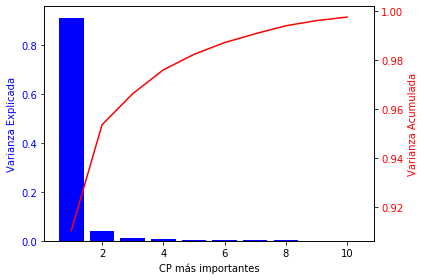

In [46]:
# visualizamos en un gráfico la proporción de la variabilidad explicada por los CP más importantes
fig, ax1 = plt.subplots()
ax1.set_xlabel('CP más importantes')
ax1.set_ylabel('Varianza Explicada', color='blue')
ax1.bar(components, autovalores, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Varianza Acumulada', color='red')
ax2.plot(components, autovalores_acum, color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.show()

Obtenemos un resultado contundente: un único autovalor (y su autovector asociado) explica más del 90% de la variabilidad de los datos del dataset original. Los dos primeros en conjunto, más del 95%. <br>
Analizamos ahora nuestro ejercicio de clusterización utilizando únicamente estos 2 componentes principales.

In [51]:
# creamos un nuevo dataset utilizando las dos primeras componentes principales
base_red = base_pca[:,0:2]

In [52]:
labels3 = []

In [53]:
# generamos sucesivos modelos de clusterización, en busca del hiperparámetro k que arroje el nro. óptimo de clusters
start_time = timeit.default_timer()
for num in [2, 4, 6, 8, 10]:
  kmeans = KMeans(n_clusters=num, random_state=14)
  kmeans.fit(base_red)
  labels3.append(kmeans.labels_)
elapsed = timeit.default_timer()-start_time
print(elapsed)

10.534843874998842


In [55]:
labels3

[array([1, 1, 0, ..., 0, 0, 1], dtype=int32),
 array([1, 1, 0, ..., 0, 0, 1], dtype=int32),
 array([1, 1, 4, ..., 4, 4, 1], dtype=int32),
 array([2, 2, 5, ..., 5, 5, 2], dtype=int32),
 array([2, 2, 6, ..., 6, 6, 2], dtype=int32)]

In [57]:
scores3 = []

In [58]:
# evaluamos el SS para estos nuevos modelos
start_time = timeit.default_timer()
for res in range (1, 6):
  scores3.append(silhouette_score(base_red, labels3[res-1], sample_size=156525))
elapsed = timeit.default_timer()-start_time
print(elapsed)

1326.9897873720001


In [59]:
scores3

[0.7162271420865228,
 0.7457034634681622,
 0.8852992245953718,
 0.9282088500658595,
 0.9693525171322142]

In [63]:
# continuamos iterando el número de clusters en busca del óptimo
start_time = timeit.default_timer()
for num in [12, 14, 16, 18, 20]:
  kmeans = KMeans(n_clusters=num, random_state=14)
  kmeans.fit(base_red)
  labels3.append(kmeans.labels_)
elapsed = timeit.default_timer()-start_time
print(elapsed)

23.817160745000365


In [64]:
labels3

[array([1, 1, 0, ..., 0, 0, 1], dtype=int32),
 array([1, 1, 0, ..., 0, 0, 1], dtype=int32),
 array([1, 1, 4, ..., 4, 4, 1], dtype=int32),
 array([2, 2, 5, ..., 5, 5, 2], dtype=int32),
 array([2, 2, 6, ..., 6, 6, 2], dtype=int32),
 array([1, 1, 6, ..., 6, 6, 1], dtype=int32),
 array([1, 1, 2, ..., 2, 2, 1], dtype=int32),
 array([1, 1, 6, ..., 6, 6, 1], dtype=int32),
 array([16, 16,  6, ...,  6,  6, 16], dtype=int32),
 array([ 3,  3,  2, ..., 18,  2,  3], dtype=int32)]

In [65]:
# evaluamos el SS para estos nuevos modelos
start_time = timeit.default_timer()
for res in range (6, 11):
  scores3.append(silhouette_score(base_red, labels3[res-1], sample_size=156525))
elapsed = timeit.default_timer()-start_time
print(elapsed)

1289.4351539580002


In [66]:
scores3

[0.7162271420865228,
 0.7457034634681622,
 0.8852992245953718,
 0.9282088500658595,
 0.9693525171322142,
 0.9882155042226756,
 0.9981052636907081,
 0.9997686187643314,
 0.6822998876633587,
 0.6254433147978506]

In [67]:
# continuamos iterando el número de clusters en busca del óptimo
start_time = timeit.default_timer()
for num in [14, 15, 16, 17]:
  kmeans = KMeans(n_clusters=num, random_state=14)
  kmeans.fit(base_red)
  labels3.append(kmeans.labels_)
elapsed = timeit.default_timer()-start_time
print(elapsed)

17.493105558000025


In [68]:
len(labels3)

14

In [69]:
# evaluamos el SS para estos nuevos modelos
start_time = timeit.default_timer()
for res in range (11, 15):
  scores3.append(silhouette_score(base_red, labels3[res-1], sample_size=156525))
elapsed = timeit.default_timer()-start_time
print(elapsed)

1047.1682422220001


In [70]:
scores3

[0.7162271420865228,
 0.7457034634681622,
 0.8852992245953718,
 0.9282088500658595,
 0.9693525171322142,
 0.9882155042226756,
 0.9981052636907081,
 0.9997686187643314,
 0.6822998876633587,
 0.6254433147978506,
 0.998283654139918,
 0.9994438151690391,
 0.9997677342625967,
 0.8306897679626585]

Nuevamente el número de clusters óptimo es 16. <br>
Sin embargo, los scores obtenidos en este último caso son superiores, indicando una separación casi perfecta entre los clusters. <br>
Vamos a graficar esto en el plano definido por los 2 componentes principales.

In [71]:
# corro por última vez la clusterización para extraer información adicional
kmeans_red = KMeans(n_clusters=16, random_state=14).fit(base_red)
centers_red = kmeans_red.cluster_centers_
labels_red = kmeans_red.labels_

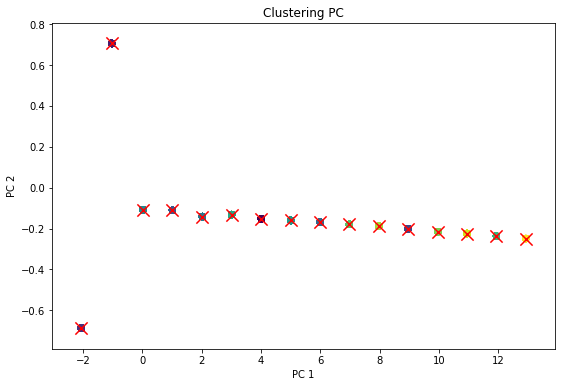

In [72]:
# Scatterplot: clustering con 2 PC
plt.figure(figsize=(9,6))
plt.scatter(base_red[:,0], base_red[:,1], c = labels_red.astype(float))
plt.scatter(centers_red[:,0], centers_red[:,1], marker = "x", color = 'r', s = 150)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Clustering PC')
plt.show()

In [80]:
# vamos a guardar la información de las etiquetas en el DataFrame
base_plot_red = base2019_dummies
base_plot_red['label'] = labels_red
base_plot.head(5)

,lat,long,ALUMBRADO,ARBOLADO Y ESPACIOS VERDES,CALLES Y VEREDAS,CEMENTERIOS,"CONTROL EDILICIO, OBRAS Y CATASTRO",FISCALIZACIÓN ACTIVIDADES COMERCIALES,LIMPIEZA Y RECOLECCIÓN,MEDIOS DE TRANSPORTE,ORDENAMIENTO DEL ESPACIO PÚBLICO,OTRAS,PLUVIALES,RECICLADO Y PROTECCIÓN AMBIENTAL,SALUD Y SERVICIOS SOCIALES,SEGURIDAD,SUGERENCIAS Y LIBRO DE QUEJAS,TRÁMITES Y SERVICIOS,TRÁNSITO,label
contacto,,,,,,,,,,,,,,,,,,,,
00000001/19,-34.634060,-58.466561,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
00000002/19,-34.628162,-58.443378,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
00000003/19,-34.623324,-58.469810,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
00000005/19,-34.618464,-58.445304,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
00000006/19,-34.634200,-58.528355,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [84]:
# guardo esta info en un csv para que pueda ser accedida sin tener que correr todo otra vez
base_plot_red.to_csv('/Users/fer/Downloads/DATASCIENCE/CLUSTER AI/GRUPO TP/SUACI/base_plot_red16.csv')

Vamos a plotear esta clusterización sobre el mapa.

In [74]:
#importamos el mapa
mapa = plt.imread('/Users/fer/Downloads/DATASCIENCE/CLUSTER AI/GRUPO TP/SUACI/mapa-CABA.png')

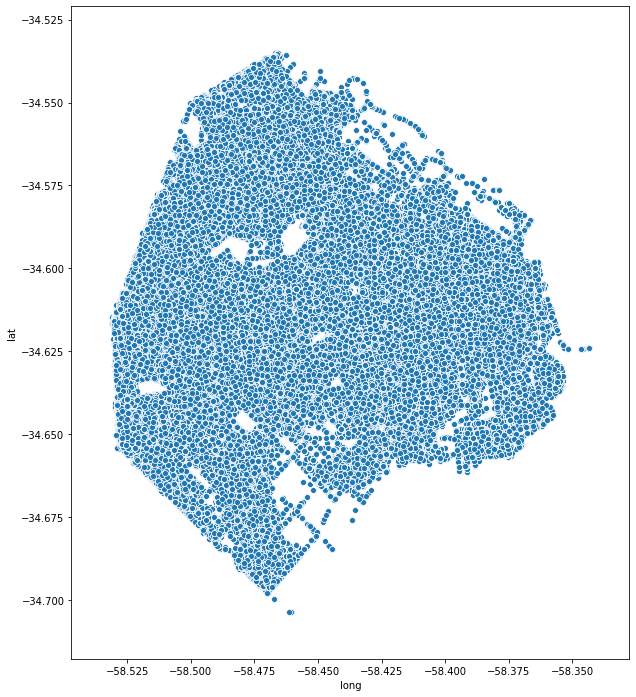

In [81]:
#plot contactos
plt.figure(figsize = (10,12))
sns.scatterplot(base_plot_red.long, base_plot_red.lat)
plt.show()

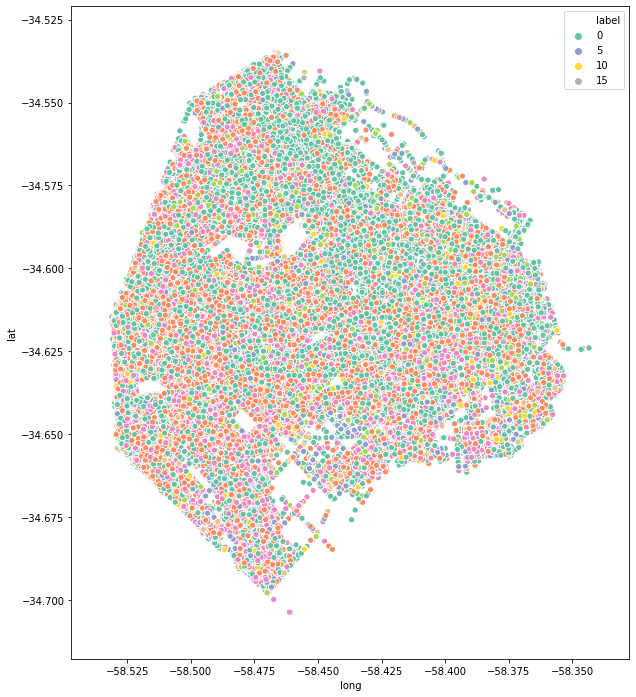

In [82]:
#  plot contactos, con distinción del cluster
plt.figure(figsize = (10,12))
sns.scatterplot(base_plot_red.long, base_plot_red.lat, hue = base_plot_red.label, palette = 'Set2')
plt.show()

Pareciera ser que la distribución de los clusters es uniforme a lo largo de la superficie de la Ciudad. Remarcamos que la separación casi perfecta de los mismos se da en el plano de los 2 primeros componentes principales, no así en el definido por las coordenadas de latitud y longitud.

Del scatterplot sobre el plano de las componentes principales, vemos un grupo de clusters bien definidos, prácticamente equidistantes, sobre lo que pareciera una recta. <br>
Podemos inferir que obedece a la agrupación en categorías de la base original, que permanece inalterada. <br>
Los dos clusters en el extremo izquierdo, sin embargo, se ven desplazados de este eje. ¿Podrá ser que en estos casos se produjo un agrupamiento?

In [85]:
base2019_red16 = base2019

In [86]:
base2019_red16['label'] = labels_red

In [87]:
# analizo categorias por cluster
base_clusters_categoria = base2019_red16.groupby(['label', 'categoria'])['canal'].count()
base_clusters_categoria

label  categoria                            
0      ALUMBRADO                                 24350
1      TRÁNSITO                                 224426
2      LIMPIEZA Y RECOLECCIÓN                   187144
3      PLUVIALES                                  3366
4      TRÁMITES Y SERVICIOS                      27469
5      FISCALIZACIÓN ACTIVIDADES COMERCIALES     11018
6      ARBOLADO Y ESPACIOS VERDES                47818
7      CALLES Y VEREDAS                          47715
8      MEDIOS DE TRANSPORTE                      17549
9      CONTROL EDILICIO, OBRAS Y CATASTRO        16487
10     SUGERENCIAS Y LIBRO DE QUEJAS              1180
11     RECICLADO Y PROTECCIÓN AMBIENTAL           7984
12     ORDENAMIENTO DEL ESPACIO PÚBLICO           4607
13     SEGURIDAD                                  3806
14     OTRAS                                      1022
15     CEMENTERIOS                                  32
       SALUD Y SERVICIOS SOCIALES                  128
Name: canal, dtype: 

Vemos que el algoritmo Kmeans agrupó las dos categorías de menor frecuencia dentro del mismo cluster. <br>
A efectos del objetivo que nos propusimos, vamos a intentar con un valor de k subóptimo, que nos permita reducir aún más el número de clusters.

In [88]:
# con k = 8 obtivimos un SS > 0.9
kmeans_red8 = KMeans(n_clusters=8, random_state=14).fit(base_red)
centers_red8 = kmeans_red8.cluster_centers_
labels_red8 = kmeans_red8.labels_

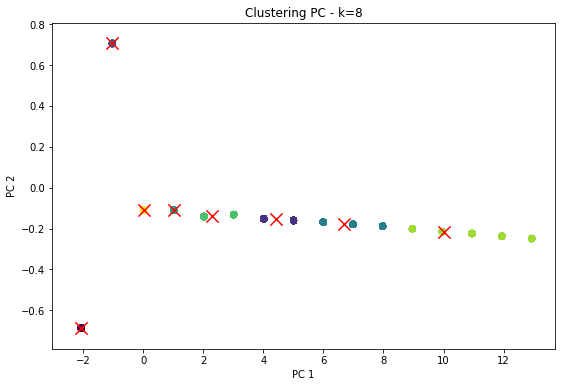

In [89]:
# Scatterplot: clustering con 2 PC
plt.figure(figsize=(9,6))
plt.scatter(base_red[:,0], base_red[:,1], c = labels_red8.astype(float))
plt.scatter(centers_red8[:,0], centers_red8[:,1], marker = "x", color = 'r', s = 150)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Clustering PC - k=8')
plt.show()

La distribución de los samples es idéntica (puesto que partimos de la misma base); vemos cómo se desplazan los centros en busca de minimizar las distancias.

In [90]:
base2019_red8 = base2019
base2019_red8['label'] = labels_red8

In [91]:
# analizo categorias por cluster
base_clusters_categoria = base2019_red16.groupby(['label', 'categoria'])['canal'].count()
base_clusters_categoria

label  categoria                            
0      LIMPIEZA Y RECOLECCIÓN                   187144
1      ALUMBRADO                                 24350
       MEDIOS DE TRANSPORTE                      17549
2      TRÁNSITO                                 224426
3      FISCALIZACIÓN ACTIVIDADES COMERCIALES     11018
       RECICLADO Y PROTECCIÓN AMBIENTAL           7984
       SEGURIDAD                                  3806
4      TRÁMITES Y SERVICIOS                      27469
5      ARBOLADO Y ESPACIOS VERDES                47818
       CONTROL EDILICIO, OBRAS Y CATASTRO        16487
6      CEMENTERIOS                                  32
       ORDENAMIENTO DEL ESPACIO PÚBLICO           4607
       OTRAS                                      1022
       PLUVIALES                                  3366
       SALUD Y SERVICIOS SOCIALES                  128
       SUGERENCIAS Y LIBRO DE QUEJAS              1180
7      CALLES Y VEREDAS                          47715
Name: canal, dtype: 